In [54]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random

In [ ]:
class Value:
    def __init__(self, data, _children = (), _op = '', label = ''):
        self.data = data
        self._prev = set(_children)
        self.grad = 0.0
        self._backward = lambda:None
        self._op = _op
        self.label = label




    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__ (self, other):
        other = other if isinstance(other,Value) else Value(other)      #assuming othe is eitherint or float
        out = Value((self.data + other.data), (self, other), _op = '+' )
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    

    def __radd__(self, other): # other + self
        return self + other


    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int and float for now"
        out = Value(self.data ** other, (self, ), f'**{other}')
        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward
        return out

    def __mul__(self, other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value((self.data * other.data), (self, other), _op = '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def __rmul__(self, other):
        return self*other
    
    def __truediv__(self, other):
        return self * (other)**(-1)

    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)

    def tanh(self):
        n = self.data
        t = (math.exp(2*n) - 1)/(math.exp(2*n)+1)
        out = Value(t, (self,), 'tanh')
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out
    


    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        
        out._backward = _backward
        return out
    



    def backward(self):
        topo = []
        visited= set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [ ]:
class Neuron:       # cell
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
        self.last_out = None

    def __call__(self, x):
        
        # we want to do w * x + b
        
        act = sum((wi*xi for wi , xi in zip(self.w, x)), self.b)
        out = act.tanh()
        self.last_out = out
        
        
        return out
    
    def parameters(self):
        return self.w + [self.b]
    
class Layer:        
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
        self.outputs = []

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        self.outputs = outs
        print(self.outputs)
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
        
        
class MLP:          
    def __init__(self, nin, nouts): # nouts will be a list
        sz = [nin] + nouts          # not nouts + [nin]
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
      
        for layer in self.layers:
            x = layer(x)
      
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
    
    def layer_outputs(self):
        return [layer.outputs for layer in self.layers]


In [109]:
x = [2.0,3.0,-1.0]
n = MLP(3, [4,4,1])
n(x)

[Value(data=0.9877791754721648), Value(data=0.5164227520096019), Value(data=-0.9449254003237271), Value(data=0.34936785691590927)]
[Value(data=0.5193083317511149), Value(data=0.0713780945020199), Value(data=-0.806459238684995), Value(data=0.4275865554749804)]
[Value(data=0.9612694478288482)]


Value(data=0.9612694478288482)

In [ ]:
list(((t for layers in n.layer_outputs() for layerouts in layers.data))

<generator object <genexpr> at 0x000001CBE322A500>

In [100]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0,1.0],
    [1.0, 1.0, -1.0],     
]
ys = [1, -1, -1, 1]



In [102]:
for k in range(2):

    #forward pass
    ypred = [n(x) for x in xs]
    loss = sum(((yout - ygt)**2 for ygt, yout in zip(ys, ypred)))

    #backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    #update
    lr = 1 - 0.001*k
    for p in n.parameters():
        p.data += -1 * lr * p.grad

    print(k, loss.data)

0 7.999999999999902
1 7.999999999999902


In [70]:
import matplotlib.pyplot as plt

In [71]:
import pandas as pd
import numpy as np

# Load data
df = pd.read_csv('mnist_train.csv')

# Split into features and labels
X = df.iloc[:, 1:].values / 255.0  # 1000, 784
y = df.iloc[:, 0].values            #1000,1

# For quick testing, use only a subset
X, y = X[:10], y[:10]


In [72]:
pexel = X.reshape(10, 28,28)

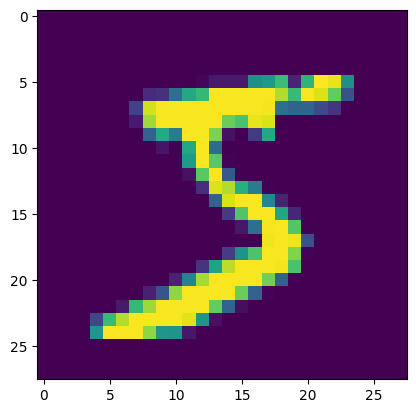

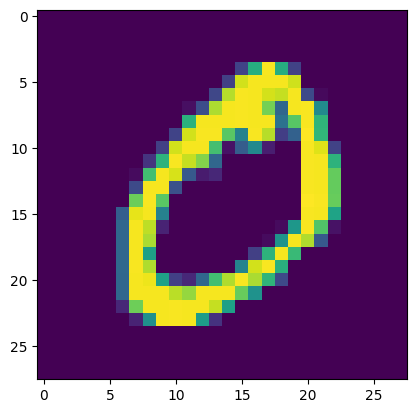

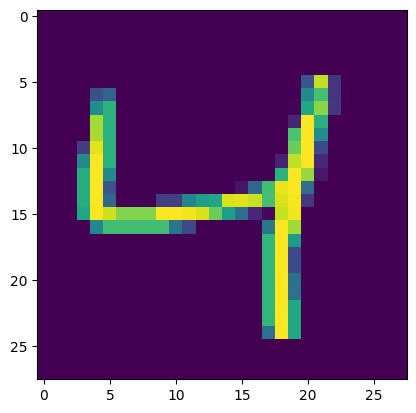

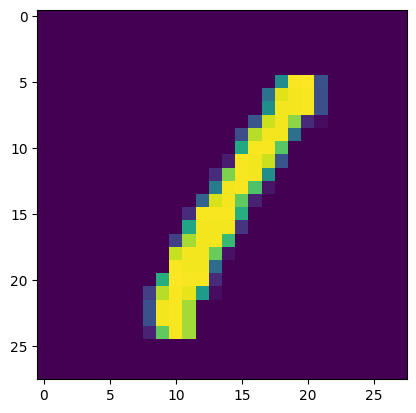

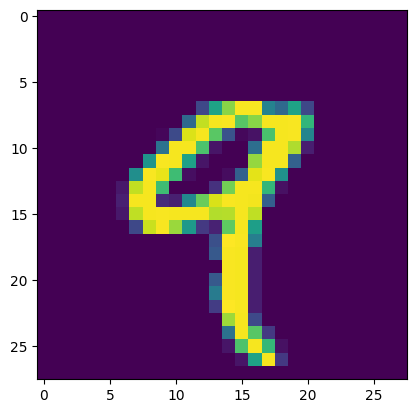

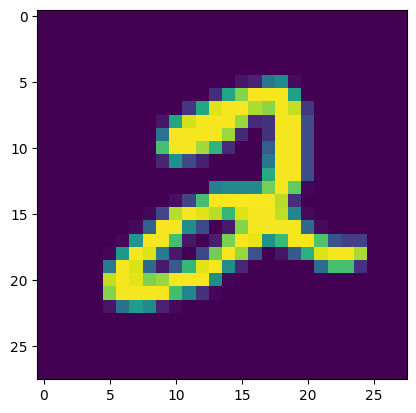

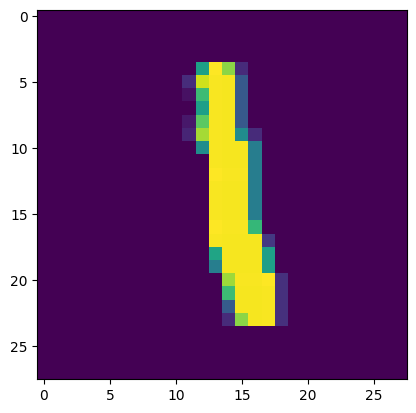

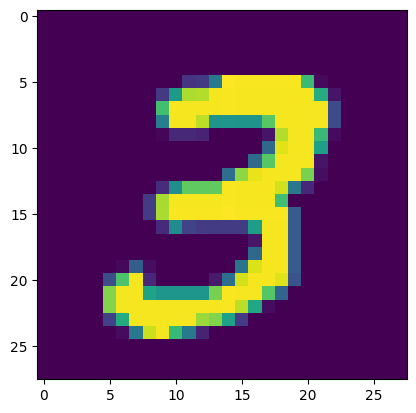

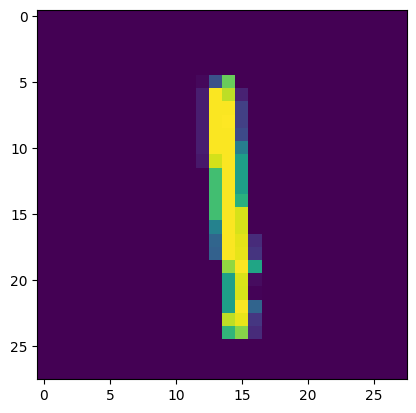

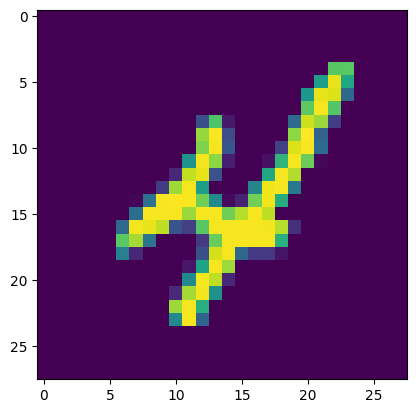

In [73]:
for i in range(10):
    plt.imshow(pexel[i])
    plt.show()

In [74]:
n = MLP(784, [121,25,10])
n(X)


TypeError: only length-1 arrays can be converted to Python scalars

In [67]:
for k in range(20):

    #forward pass
    ypred = [n(x) for x in X]
    loss = sum(((yout - ygt)**2 for ygt, yout in zip(y, ypred)))

    #backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    #update
    lr = 0.01
    for p in n.parameters():
        p.data += -1 * lr * p.grad

    print(k, loss.data)

KeyboardInterrupt: 